In [2]:
import pymc as pm
import arviz as az

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from thesis_tools.models.frequentist import *

# Pareto

In [47]:
n_covariates = 2
T = 2
true_betas = [-1, 1]
n_obs = np.random.randint(50, 100, size=T)
X = np.random.normal(0, 1, size=(T-1, n_covariates))

alpha_0 = 0.5
true_alphas = [alpha_0]
for i in range(0, T-1):
    true_alphas.append(true_alphas[-1] * np.exp(np.dot(X[i], true_betas)))

y = []
for i in range(0, T):
    y.append(Pareto(x_m=1, alpha=true_alphas[i]).sample(n_obs[i]))

In [48]:
true_betas

[-1, 1]

In [49]:
true_alphas

[0.5, 0.48407027985974127]

In [50]:
pareto_model = pm.Model()

with pareto_model:
    initial_alpha = pm.Gamma('initial_alpha', alpha=1, beta=1)
    alpha = [initial_alpha]

    betas = []
    for i in range(0, n_covariates):
        beta_sigma = pm.Gamma(f'beta_sigma_{i}', alpha=1, beta=1)
        beta = pm.Normal(f'beta_{i}', mu=0, sigma=beta_sigma)
        betas.append(beta)

    for i in range(0, T-1):
        alpha.append(alpha[-1] * pm.math.exp(pm.math.dot(X[i], betas)))

    y_obs = []
    for t in range(0, T):
        y_obs.append(pm.Pareto(f'y_{t}', alpha=alpha[t], m=1, observed=y[t]))

In [51]:
with pareto_model:
    pareto_trace = pm.sample(1000, tune=1000, nuts_sampler='nutpie')

In [52]:
az.summary(pareto_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.118,1.257,-2.489,2.515,0.069,0.049,406.0,311.0,1.02
beta_1,0.308,1.022,-1.485,2.501,0.044,0.031,636.0,592.0,1.01
beta_sigma_0,1.017,0.955,0.051,2.831,0.049,0.034,221.0,123.0,1.03
beta_sigma_0_log__,-0.425,1.009,-2.452,1.163,0.070,0.054,221.0,123.0,1.03
beta_sigma_1,0.934,0.846,0.059,2.425,0.035,0.025,304.0,155.0,1.01
beta_sigma_1_log__,-0.479,0.969,-2.260,1.247,0.056,0.049,304.0,155.0,1.01
initial_alpha,2.151,0.212,1.769,2.572,0.007,0.005,955.0,1728.0,1.01
initial_alpha_log__,0.761,0.099,0.581,0.953,0.003,0.002,955.0,1728.0,1.01


In [53]:
true_alphas

[0.5, 0.48407027985974127]

# Weibull

In [84]:
n_covariates = 2
T = 2
true_betas = [-1, 1]
n_obs = np.random.randint(50, 100, size=T)
X = np.random.normal(0, 1, size=(T-1, n_covariates))

common_shape = 0.25
true_alphas = [1]
for i in range(0, T-1):
    true_alphas.append(true_alphas[-1] * np.exp(np.dot(X[i], true_betas)))

y = []
for i in range(0, T):
    y.append(np.random.weibull(common_shape, size=n_obs[i]) * true_alphas[i])

In [85]:
weibull_model = pm.Model()

with weibull_model:
    initial_alpha = pm.Gamma('initial_alpha', alpha=1, beta=1)
    alpha = [initial_alpha]

    betas = []
    for i in range(0, n_covariates):
        beta_sigma = pm.Gamma(f'beta_sigma_{i}', alpha=1, beta=1)
        beta = pm.Normal(f'beta_{i}', mu=0, sigma=beta_sigma)
        betas.append(beta)

    for i in range(0, T-1):
        error = pm.Normal(f'error_{i}', mu=0, sigma=1)
        alpha.append(alpha[-1] * pm.math.exp(pm.math.dot(X[i], betas) + error))

    y_obs = []
    for t in range(0, T):
        y_obs.append(pm.Weibull(f'y_{t}', alpha=common_shape, beta=alpha[t], observed=y[t]))

In [86]:
with weibull_model:
    weibull_trace = pm.sample(1000, tune=1000, nuts_sampler='nutpie')

In [87]:
az.summary(weibull_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-0.578,1.009,-2.800,1.061,0.037,0.027,863.0,970.0,1.00
beta_1,0.545,0.886,-0.865,2.379,0.034,0.024,794.0,844.0,1.00
beta_sigma_0,1.056,0.932,0.059,2.713,0.029,0.021,745.0,522.0,1.00
beta_sigma_0_log__,-0.337,0.944,-2.238,1.228,0.035,0.027,745.0,522.0,1.00
beta_sigma_1,1.005,0.899,0.051,2.576,0.027,0.019,707.0,376.0,1.01
beta_sigma_1_log__,-0.395,0.968,-2.537,1.061,0.037,0.036,707.0,376.0,1.01
error_0,0.640,0.913,-1.147,2.246,0.026,0.019,1219.0,1656.0,1.00
initial_alpha,1.248,0.476,0.467,2.094,0.012,0.008,1572.0,2186.0,1.00
initial_alpha_log__,0.152,0.376,-0.582,0.816,0.009,0.007,1572.0,2186.0,1.00


In [88]:
true_betas

[-1, 1]

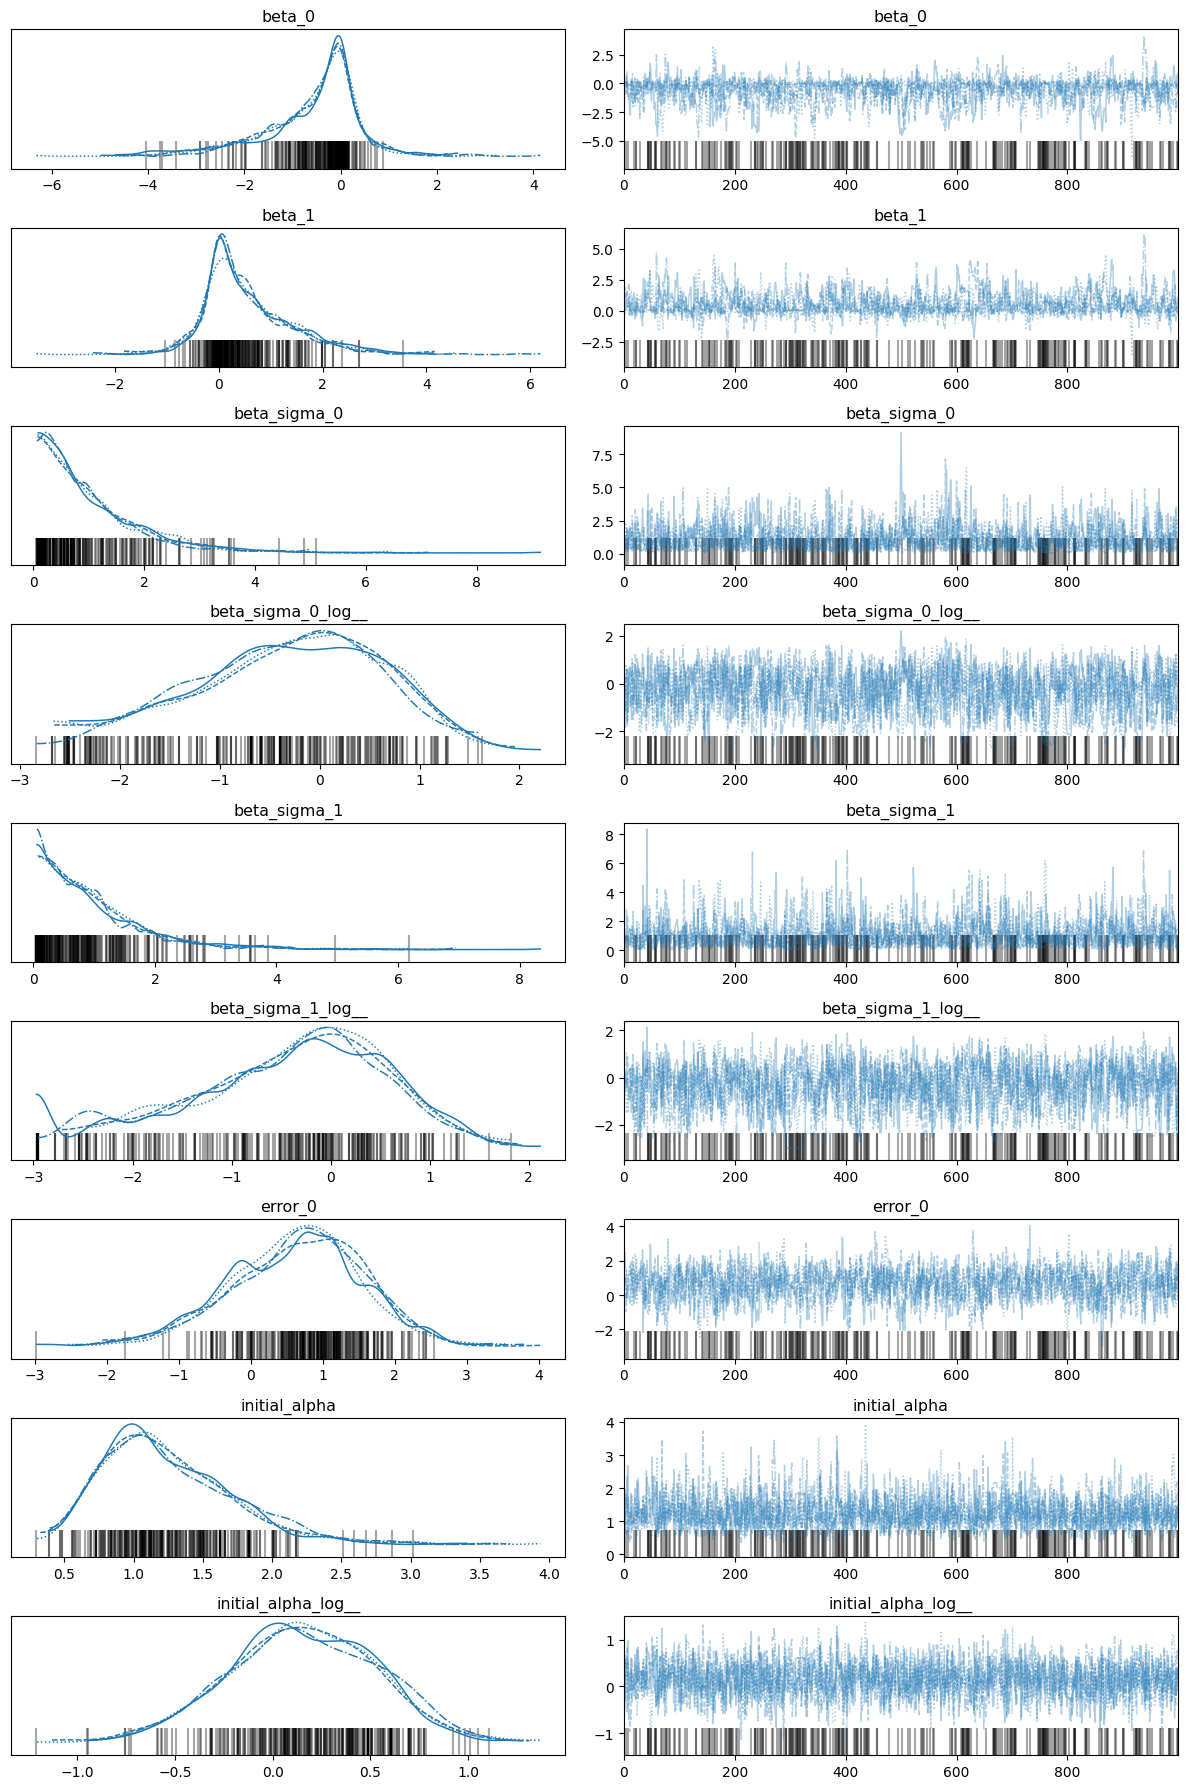

In [89]:
az.plot_trace(weibull_trace)
plt.tight_layout()

# Generalised Pareto

In [101]:
n_covariates = 2
T = 20
true_betas = [-1, 1]
n_obs = np.random.randint(50, 100, size=T)
X = np.random.normal(0, 1, size=(T-1, n_covariates))

common_gamma = 0.45
true_sigmas = [1]
for i in range(0, T-1):
    true_sigmas.append(true_sigmas[-1] * np.exp(np.dot(X[i], true_betas)))

y = []
for i in range(0, T):
    y.append(GeneralisedPareto(mu=1, gamma=common_gamma, sigma=true_sigmas[i]).sample(n_obs[i]))

In [102]:
generalised_pareto_model = pm.Model()

with generalised_pareto_model:
    initial_sigma = pm.Gamma('initial_sigma', alpha=1, beta=1)
    sigma = [initial_sigma]

    betas = []
    for i in range(0, n_covariates):
        beta_sigma = pm.Gamma(f'beta_sigma_{i}', alpha=1, beta=1)
        beta = pm.Normal(f'beta_{i}', mu=0, sigma=beta_sigma)
        betas.append(beta)

    for i in range(0, T-1):
        sigma.append(sigma[-1] * pm.math.exp(pm.math.dot(X[i], betas)))

    # Functions for the custom distribution
    def gpd_logp(value, mu, gamma, sigma):
        if gamma == 0:
            return -np.log(sigma) - (value - mu) / sigma
        else:
            return -np.log(sigma) - (1 + 1 / gamma) * np.log(1 + gamma * (value - mu) / sigma)

    def gpd_random(mu, gamma, sigma, rng=None, size=None):
        # generate uniforms
        u = rng.uniform(size=size)
        if gamma == 0:
            return mu - sigma * np.log(1-u)
        else:
            return mu + sigma * ((1 / (1 - u)**gamma - 1)) / gamma

    y_obs = []
    for t in range(0, T):
        mu = 1
        y_obs.append(pm.CustomDist(f'y_{t}', mu, common_gamma, sigma[t], logp=gpd_logp, random=gpd_random, observed=y[t]))

In [103]:
with generalised_pareto_model:
    generalised_pareto_trace = pm.sample(1000, tune=1000, nuts_sampler='nutpie')

In [104]:
az.summary(generalised_pareto_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-1.021,0.028,-1.075,-0.970,0.001,0.000,2727.0,3038.0,1.0
beta_1,1.002,0.015,0.972,1.028,0.000,0.000,1812.0,2058.0,1.0
beta_sigma_0,1.314,0.770,0.342,2.729,0.014,0.011,3893.0,2833.0,1.0
beta_sigma_0_log__,0.132,0.520,-0.851,1.074,0.009,0.008,3893.0,2833.0,1.0
beta_sigma_1,1.297,0.787,0.334,2.695,0.014,0.010,3786.0,3243.0,1.0
beta_sigma_1_log__,0.115,0.525,-0.806,1.137,0.009,0.007,3786.0,3243.0,1.0
initial_sigma,0.993,0.061,0.885,1.111,0.001,0.001,1937.0,2227.0,1.0
initial_sigma_log__,-0.009,0.061,-0.122,0.105,0.001,0.001,1937.0,2227.0,1.0


array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_sigma_0'}>,
        <Axes: title={'center': 'beta_sigma_0'}>],
       [<Axes: title={'center': 'beta_sigma_0_log__'}>,
        <Axes: title={'center': 'beta_sigma_0_log__'}>],
       [<Axes: title={'center': 'beta_sigma_1'}>,
        <Axes: title={'center': 'beta_sigma_1'}>],
       [<Axes: title={'center': 'beta_sigma_1_log__'}>,
        <Axes: title={'center': 'beta_sigma_1_log__'}>],
       [<Axes: title={'center': 'initial_sigma'}>,
        <Axes: title={'center': 'initial_sigma'}>],
       [<Axes: title={'center': 'initial_sigma_log__'}>,
        <Axes: title={'center': 'initial_sigma_log__'}>]], dtype=object)

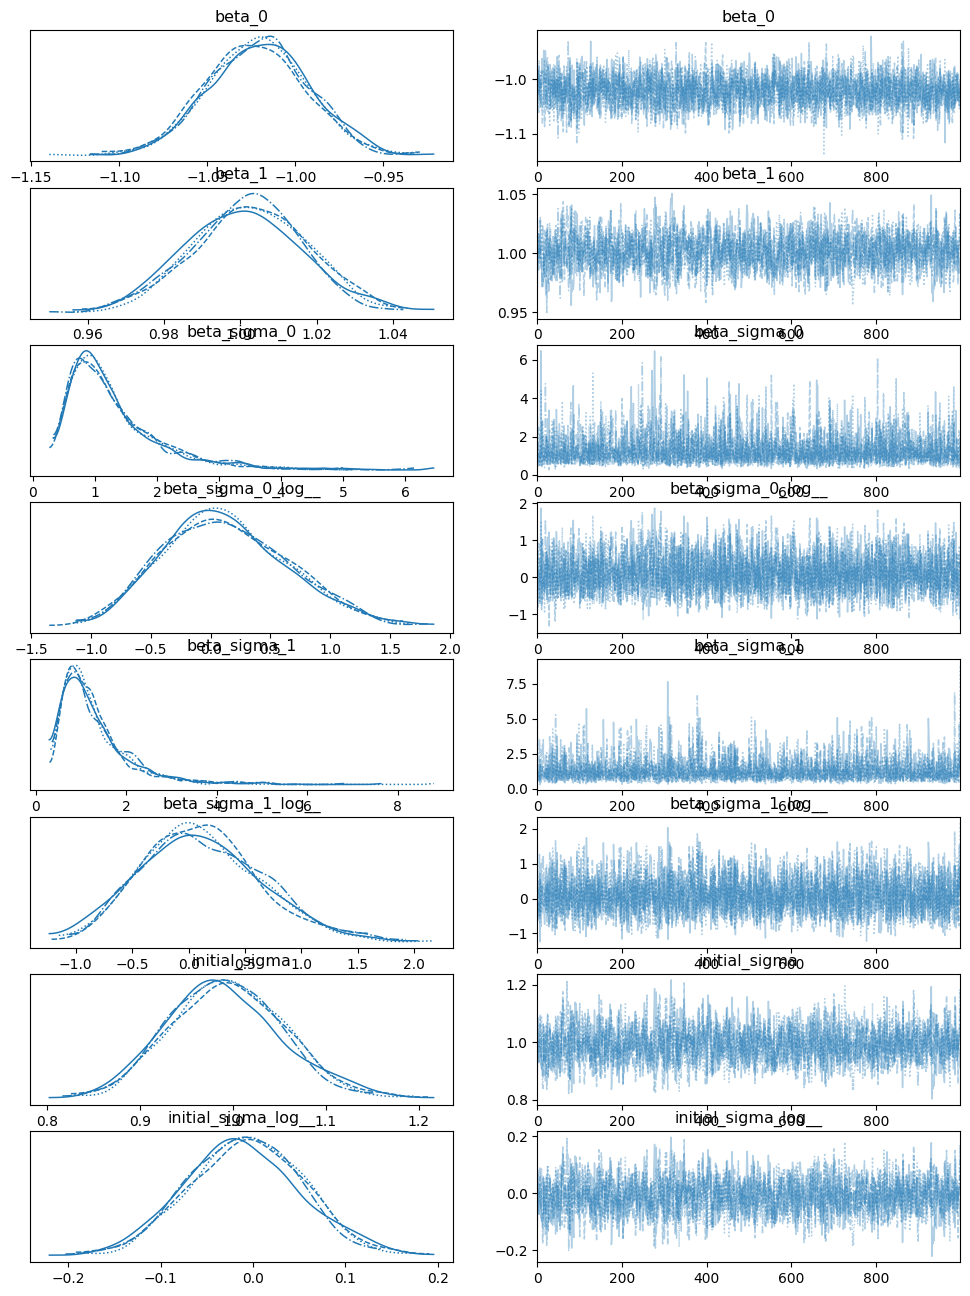

In [105]:
az.plot_trace(generalised_pareto_trace)

# Multivariate GPD